# Environment Setup

In [48]:
import numpy as np
import gym

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import seaborn as sns

In [3]:
sns.set()

In [4]:
env = gym.make('MountainCar-v0')

# Q Learning With Linear Approximation

/home/haskell/.local/share/anaconda3/envs/gym/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


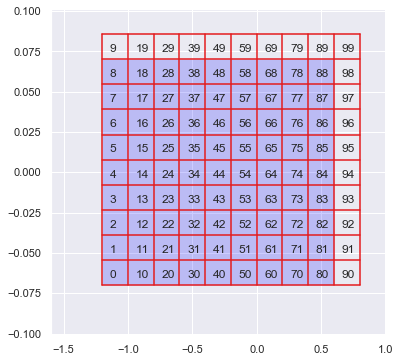

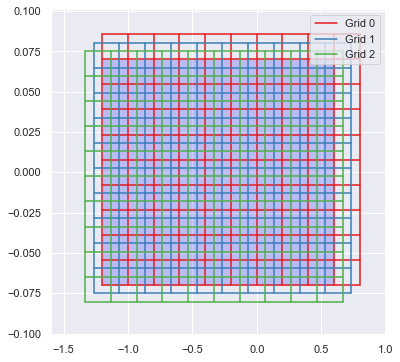

In [149]:
def plot_tile_grids(env, tiles, tilings, filename):
    
    obs = env.observation_space
    
    cmap = cm.get_cmap('Set1')
    
    plt.figure(figsize=(6, 6))
    
    value_range = np.zeros((2, 2))
    
    xlb, ylb = obs.low
    xub, yub = obs.high
    xstep, ystep = (obs.high - obs.low) / (np.array(tiles) - 1)
    
    for tiling in range(tilings):
        
        offset_ratio = tiling / tilings
        
        xs = np.arange(0, tiles[0] + 1) * xstep + xlb - xstep * offset_ratio
        ys = np.arange(0, tiles[1] + 1) * ystep + ylb - ystep * offset_ratio
        
        for x in xs:
            plt.gca().add_line(Line2D([x, x], [ys[0], ys[-1]], color=cmap(tiling)))
        
        for y in ys:
            plt.gca().add_line(Line2D([xs[0], xs[-1]], [y, y], color=cmap(tiling)))
            
    plt.xlim(xlb - 2 * xstep, xub + 2 * xstep)
    plt.ylim(ylb - 2 * ystep, yub + 2 * ystep)
                
    patch = patches.Rectangle((obs.low), *(obs.high - obs.low), facecolor='blue', fill=True, alpha=0.2, label='value-range')
    plt.axes().add_patch(patch)
    
    if tilings > 1:
        custom_lines = [Line2D([0], [0], color=cmap(i)) for i in range(tilings)]
        plt.legend(custom_lines, [f'Grid {i}' for i in range(tilings)], loc='upper right')
    else:
        state = np.arange(np.prod(tiles)).reshape(tiles)
        for x, y in np.ndindex(tiles):
            idx = state[x, y]
            plt.text(x * xstep + 0.3 * xstep + xlb, y * ystep + 0.3 * ystep + ylb, f'{idx}')
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    
    
plot_tile_grids(env, (10, 10), 1, 'tile-encoding-1.png')    
plot_tile_grids(env, (10, 10), 3, 'tile-encoding-3.png')    

In [152]:
def make_activate(env, tiles, tilings):
    "make activate function which encode state into tile coding"
    
    obs = env.observation_space
    lb, ub = obs.low, obs.high
    
    units = np.hstack([[1], np.cumprod((tilings, ) + tuple(tiles))])[:-1]
    scale = np.diag((np.array(tiles) - 1) / (ub - lb))
    
    offset = np.arange(tilings) / tilings
    
    def feature(x, debug=False):
        fs = np.column_stack([
            np.arange(tilings), 
            np.floor((scale @ (x - lb)).reshape(1, -1) + offset.reshape(-1, 1)).astype(int)
        ])
        
        return units @ fs.T
    
    return feature

### Q-Learning

In [165]:
n_action = env.action_space.n

# How many epoch and max_steps we train 
n_epoch = 1000
n_maxstep = 300

# Feature extraction function with 20 10x10 tiles 
activate = make_activate(env, [10, 10], 20)

# Linear weight
W = np.zeros((10 * 10 * 20, 3))

# Learning rate
α = 0.01

# Discount, as the task is episodic we can make it equal to 1
γ = 1

# Linear degraded ϵ
ϵ_space = np.linspace(1, 0.05, n_epoch // 2)


with tqdm(range(n_epoch)) as prog:
    for epoch in prog:
        state = env.reset()
        ϵ = ϵ_space[min(epoch, ϵ_space.shape[0] - 1)]

        # the environment we use is actually time bounded, we can also use `while True:`
        for _ in range(n_maxstep):
            s = activate(state)

            if np.random.rand() < ϵ:
                action = env.action_space.sample()
            else:
                values = np.sum(W[s, :], axis=0)
                action = np.random.choice(np.arange(n_action)[values == np.max(values)])

            state_next, reward, is_done, _ = env.step(action)
            sp = activate(state_next)
                
            expected = reward + γ * np.max(np.sum(W[sp], axis=0)) * (1 - is_done)
            W[s, action] += α * (expected - np.sum(W[s, action]))

            if is_done:
                break
            state = state_next

100%|██████████| 1000/1000 [00:16<00:00, 58.93it/s]


### Demo

In [179]:
from PIL import Image
import os

image_path = 'anim'

if not os.path.exists(image_path):
    os.makedirs(image_path)

try:
    state = env.reset()
        
    for i in range(1000):
        arr = env.render(mode='rgb_array')
        
        image = Image.fromarray(arr)
        image.save(os.path.join(image_path, f'{i:03}.png'))
        
        s = activate(state)

        values = np.sum(W[s, :], axis=0)
        action = np.random.choice(np.arange(n_action)[values == np.max(values)])

        state_next, reward, is_done, _ = env.step(action)

        if is_done:
            break
        state = state_next
finally:
    env.close()

### Generate gif with png frames

In [186]:
!convert -delay 1 -loop 0 anim/*png mountain-car.gif 